# Example of using our Proposed Spatio-Temporal Graph Neural Networks

## Import libraries

In [1]:
from stgraph_trainer.datasets import load_province_temporal_data
from stgraph_trainer.datasets import load_province_coordinates
from stgraph_trainer.datasets import preprocess_data_for_stgnn
from stgraph_trainer.utils import PairDataset
from stgraph_trainer.utils import compute_metrics
from stgraph_trainer.utils import get_distance_in_km_between_earth_coordinates
from stgraph_trainer.utils import get_adjacency_matrix
from stgraph_trainer.utils import get_normalized_adj
from torch.utils.data import DataLoader
from stgraph_trainer.models import ProposedSTGNN
from stgraph_trainer.trainers import ProposedSTGNNTrainer
import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [133]:
!pip3 install -U matplotlib


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 7.5 MB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 2.8 MB 22.6 MB/s eta 0:00:01
  Using cached pyparsing-3.1.2-py3-none-any.whl (103 kB)
     |████████████████████████████████| 66 kB 6.8 MB/s eta 0:00:011
     |████████████████████████████████| 244 kB 18.5 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


## Load and process dataset
### Setup parameters

In [2]:
SPLIT_DATE = '2021-05-29'
TIME_STEPS = 7
STATUS = 'New'
BATCH_SIZE = 16
EPOCHS = 10
device = torch.device('cuda', 0) if torch.cuda.is_available() else torch.device('cpu')

### Temporal data

In [3]:
df = pd.read_csv('../notebooks/stgraph_trainer/datasets/data/water_nitrite (1).csv', index_col=0)
df = df.set_index('dateTime')

#df = load_province_temporal_data(provinces=PROVINCES, status=STATUS)
#X_train, y_train, X_test, y_test, _, _, scaler = preprocess_data_for_stgnn(df_first_91,
          #                                                                 SPLIT_DATE,
           #                                                                TIME_STEPS)



In [5]:
X_train, y_train, X_test, y_test, _, _, scaler = preprocess_data_for_stgnn(df_summer,
                                                                           SPLIT_DATE,
                                                                           TIME_STEPS)

In [88]:
df.drop(index=df.index[:91], axis=0, inplace=True)

In [91]:
df.drop(index=df.index[:92], axis=0, inplace=True)

In [4]:
df_summer = df.head(91)

In [41]:
df_winter = df.head(92)

,4175748,4176063,4176617,4177080,4177266,4178000,4181049,4182000,4183000,4183038,...,4185935,4186500,4188100,4188496,4190000,4191058,4191444,4191500,4192500,41843678
dateTime,,,,,,,,,,,,,,,,,,,,,
2021-04-01,4.136982,4.136982,4.136982,2.450,2.62,3.79,4.89,5.52,5.95,7.1,...,3.61,5.26,5.83,2.62,5.03,8.61,19.40,8.03,6.57,4.136982
2021-04-02,4.132495,4.132495,4.132495,2.080,2.10,3.41,4.34,4.82,5.40,7.1,...,3.37,4.79,5.37,2.20,4.71,7.99,18.80,7.60,6.29,4.132495
2021-04-03,4.128007,4.128007,4.128007,1.850,1.73,3.08,3.95,4.20,4.99,7.1,...,3.29,4.32,5.01,2.00,4.43,7.37,18.80,7.17,5.94,4.128007
2021-04-04,4.123519,4.123519,4.123519,1.620,1.38,2.80,3.59,3.72,4.65,7.1,...,3.23,3.92,4.65,1.81,4.14,7.00,18.70,6.74,5.59,4.123519
2021-04-05,4.119031,4.119031,4.119031,1.470,1.18,2.54,3.32,3.39,4.30,7.1,...,3.16,3.69,4.29,1.72,3.87,6.82,18.70,6.31,5.24,4.119031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-28,1.380000,4.710000,4.600000,1.120,1.76,1.75,4.96,4.17,2.80,5.6,...,4.35,5.34,4.34,3.99,4.80,5.86,9.00,4.57,3.54,2.290000
2022-03-29,1.380000,4.300000,4.330000,1.070,1.59,1.69,4.76,3.58,2.67,4.9,...,4.09,5.05,4.27,3.80,4.60,6.05,8.42,4.94,3.46,2.140000
2022-03-30,1.370000,4.240000,4.210000,1.010,1.43,1.61,4.55,3.14,2.60,4.8,...,3.86,4.77,4.23,3.63,4.38,5.83,7.73,5.31,3.35,2.020000


In [6]:
X_train = torch.tensor(X_train).unsqueeze(-1)
y_train = torch.tensor(y_train).unsqueeze(-1)
X_test = torch.tensor(X_test).unsqueeze(-1)
y_test = torch.tensor(y_test).unsqueeze(-1)
n_test_samples = len(y_test)

In [ ]:
df_spring = df.loc[(df[''].month==1)]


In [5]:
df = pd.read_csv('../notebooks/stgraph_trainer/datasets/data/water_nitrite (1).csv', index_col=0)
df = df.set_index('dateTime')

In [113]:
gageid = list(df.columns)

In [7]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

/var/folders/5j/dqs14tt521l07kmnht1dl6q80000gn/T/ipykernel_19476/3899881845.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
/var/folders/5j/dqs14tt521l07kmnht1dl6q80000gn/T/ipykernel_19476/3899881845.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)
/var/folders/5j/dqs14tt521l07kmnht1dl6q80000gn/T/ipykernel_19476/3899881845.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)
/va

In [59]:
df_first_91 = df.head(91)

In [7]:
df_first_91

,4175748,4176063,4176617,4177080,4177266,4178000,4181049,4182000,4183000,4183038,...,4185935,4186500,4188100,4188496,4190000,4191058,4191444,4191500,4192500,41843678
dateTime,,,,,,,,,,,,,,,,,,,,,
2021-04-01,4.136982,4.136982,4.136982,2.45,2.62,3.79,4.89,5.52,5.95,7.1,...,3.61,5.26,5.83,2.62,5.03,8.61,19.40,8.03,6.57,4.136982
2021-04-02,4.132495,4.132495,4.132495,2.08,2.10,3.41,4.34,4.82,5.40,7.1,...,3.37,4.79,5.37,2.20,4.71,7.99,18.80,7.60,6.29,4.132495
2021-04-03,4.128007,4.128007,4.128007,1.85,1.73,3.08,3.95,4.20,4.99,7.1,...,3.29,4.32,5.01,2.00,4.43,7.37,18.80,7.17,5.94,4.128007
2021-04-04,4.123519,4.123519,4.123519,1.62,1.38,2.80,3.59,3.72,4.65,7.1,...,3.23,3.92,4.65,1.81,4.14,7.00,18.70,6.74,5.59,4.123519
2021-04-05,4.119031,4.119031,4.119031,1.47,1.18,2.54,3.32,3.39,4.30,7.1,...,3.16,3.69,4.29,1.72,3.87,6.82,18.70,6.31,5.24,4.119031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-26,12.700000,18.800000,9.600000,10.00,9.69,5.36,3.40,7.42,6.67,16.4,...,3.84,1.51,3.15,2.80,3.38,3.33,21.40,5.50,6.22,13.600000
2021-06-27,11.900000,22.100000,8.920000,9.34,8.02,7.74,3.22,5.62,8.57,11.7,...,4.01,1.42,2.98,3.89,3.35,3.72,27.60,5.77,6.73,10.900000
2021-06-28,5.140000,12.900000,8.960000,7.75,6.29,9.15,3.11,4.48,9.84,9.6,...,4.05,1.44,3.01,16.00,3.38,4.17,22.20,6.07,7.23,8.920000


In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([50, 24, 7, 1]),
 torch.Size([50, 24, 1]),
 torch.Size([33, 24, 7, 1]),
 torch.Size([33, 24, 1]))

In [25]:
X_train.shape[3]

IndexError: tuple index out of range

In [16]:
train_dl = DataLoader(PairDataset(X_train, y_train),
                      batch_size=BATCH_SIZE,
                      shuffle=True)

In [9]:
df = pd.read_csv('../notebooks/stgraph_trainer/datasets/data/adjmatrix (1).csv', sep=',')

In [85]:
adj

tensor([[0.4069, 0.1779, 0.0000, 0.0793, 0.0339, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.1162, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1586],
        [0.1779, 0.4246, 0.0458, 0.0553, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.1248, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1445],
        [0.0000, 0.0458, 0.9322, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0793, 0.0553, 0.0000, 0.3530, 0.1638, 0.0314, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0170, 0.1186, 0.0466, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0187, 0.1215],
        [0.0339, 0.0000, 0.0000, 0.1638, 0.4494, 0.0669, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0249, 0.0681

### Spatial data

In [34]:
province_coords = arr

dist_km = []
for idx, c1 in enumerate(arr):
  dist_km.append([get_distance_in_km_between_earth_coordinates(c1, c2) for c2 in arr])
dist_mx = np.array(dist_km)

adj_mx = get_adjacency_matrix(dist_mx)
# Fix formatting
adj_mx = adj_mx.astype(np.float32)

adj_mx = get_normalized_adj(adj_mx)
adj = torch.tensor(adj_mx)
adj.shape

torch.Size([24, 24])

In [35]:
adj

tensor([[0.4069, 0.1779, 0.0000, 0.0793, 0.0339, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.1162, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1586],
        [0.1779, 0.4246, 0.0458, 0.0553, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.1248, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1445],
        [0.0000, 0.0458, 0.9322, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0793, 0.0553, 0.0000, 0.3530, 0.1638, 0.0314, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0170, 0.1186, 0.0466, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0187, 0.1215],
        [0.0339, 0.0000, 0.0000, 0.1638, 0.4494, 0.0669, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0249, 0.0681

In [10]:
adj = df
adj.shape
adj = adj.astype(np.float32)
adj = adj.to_numpy()


In [11]:
adj = torch.tensor(adj)


In [308]:
province_coords = arr

dist_km = []
for idx, c1 in enumerate(arr):
  dist_km.append([get_distance_in_km_between_earth_coordinates(c1, c2) for c2 in arr])
dist_mx = np.array(dist_km)

adj_mx = get_adjacency_matrix(dist_mx)

In [176]:
def get_normalized_adj(A):
  """
  Returns the degree normalized adjacency matrix.
  """
  A = A + np.diag(np.ones(A.shape[0], dtype=np.float32))
  D = np.array(np.sum(A, axis=1)).reshape((-1,))
  D[D <= 10e-5] = 10e-5    # Prevent infs
  diag = np.reciprocal(np.sqrt(D))
  A_wave = np.multiply(np.multiply(diag.reshape((-1, 1)), A),
                        diag.reshape((1, -1)))
  return A

In [22]:
adj = adj.to_numpy()

In [12]:
adj.shape

torch.Size([24, 24])

In [28]:
df = pd.read_csv('../notebooks/stgraph_trainer/datasets/data/geonew.csv',index_col=0)
df = df.sort_values(by=['site_no'], ascending=True)
df = df.drop_duplicates() 
arr = df[['latitude', 'longitude']].to_numpy()
 
#df.pivot(index='v', columns='t', values='value').to_numpy()

In [29]:
df = df.drop_duplicates() 

In [33]:
arr.shape

(24, 2)

## Train the model

In [36]:
model = ProposedSTGNN(n_nodes=adj.shape[0],
                      time_steps=TIME_STEPS,
                      predicted_time_steps=1,
                      in_channels=X_train.shape[3],
                      spatial_channels=32,
                      spatial_hidden_channels=16,
                      spatial_out_channels=16,
                      out_channels=16,
                      temporal_kernel=3,
                      drop_rate=0.2).to(device=device)

In [47]:
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [48]:
trainer = ProposedSTGNNTrainer(model,
                               train_dl,
                               X_test,
                               adj,
                               scaler,
                               loss_func,
                               optimizer,
                               device,
                               callbacks=None,
                               raw_test=df_summer.iloc[-(n_test_samples + 1):].values)

In [115]:
df_first_91.iloc[-(n_test_samples + 1):].values[:-1].shape

(33, 24)

In [49]:
history = trainer.train(10)
history['train_loss']

Epoch: 1; Elapsed time: 0.02680802345275879; Train loss: 1.077988; Test MSE: 5.036361; Test loss RMSE: 2.244184
Epoch: 2; Elapsed time: 0.016381263732910156; Train loss: 0.805844; Test MSE: 5.039340; Test loss RMSE: 2.244847
Epoch: 3; Elapsed time: 0.017858028411865234; Train loss: 0.999956; Test MSE: 4.973971; Test loss RMSE: 2.230240
Epoch: 4; Elapsed time: 0.011137962341308594; Train loss: 0.777087; Test MSE: 4.937799; Test loss RMSE: 2.222116
Epoch: 5; Elapsed time: 0.013267993927001953; Train loss: 0.774558; Test MSE: 4.912923; Test loss RMSE: 2.216511
Epoch: 6; Elapsed time: 0.012920141220092773; Train loss: 0.787791; Test MSE: 4.916955; Test loss RMSE: 2.217421
Epoch: 7; Elapsed time: 0.011198997497558594; Train loss: 0.854857; Test MSE: 4.935347; Test loss RMSE: 2.221564
Epoch: 8; Elapsed time: 0.011026859283447266; Train loss: 0.762642; Test MSE: 4.859079; Test loss RMSE: 2.204332
Epoch: 9; Elapsed time: 0.011075735092163086; Train loss: 0.757476; Test MSE: 4.772696; Test loss

[1.077988475561142,
 0.8058436848223209,
 0.9999558925628662,
 0.7770870197564363,
 0.7745583448559046,
 0.7877908833324909,
 0.8548568114638329,
 0.7626417148858309,
 0.7574761360883713,
 1.2913680970668793]

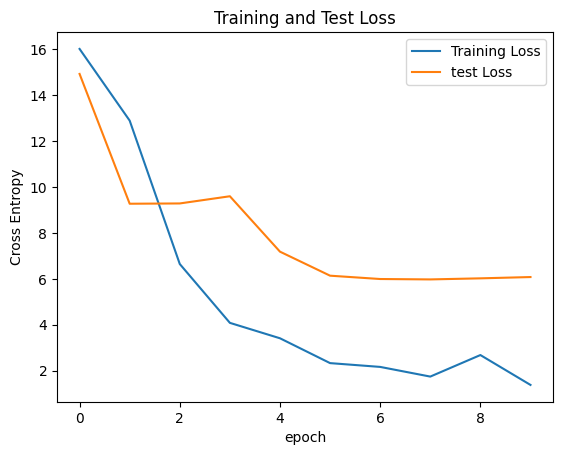

In [21]:
loss = history['train_loss']
test_loss = history['test_loss']
plt.plot(loss, label='Training Loss')
plt.plot(test_loss, label='test Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Test Loss')
plt.xlabel('epoch')
plt.show() 

## Prediction

In [50]:
predictions = trainer.predict()

In [69]:
predictions.shape

(33, 24)

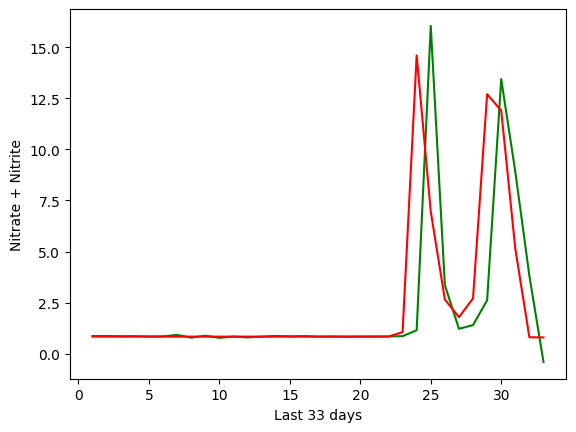

In [108]:
import numpy as np 
import matplotlib.pyplot as plt 
 
# data to be plotted
x = np.arange(1, 34) 
#y = mean
#y1 = mean_test

y = first_gage
y1 = first_gage1
# plotting
plt.title("") 
plt.xlabel("Last 33 days") 
plt.ylabel("Nitrate + Nitrite") 
plt.plot(x, y, color ="green") # test set
plt.plot(x, y1, color = "red") # 
plt.show()

In [52]:
adj

tensor([[0.4069, 0.1779, 0.0000, 0.0793, 0.0339, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.1162, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1586],
        [0.1779, 0.4246, 0.0458, 0.0553, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.1248, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1445],
        [0.0000, 0.0458, 0.9322, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0793, 0.0553, 0.0000, 0.3530, 0.1638, 0.0314, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0170, 0.1186, 0.0466, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0187, 0.1215],
        [0.0339, 0.0000, 0.0000, 0.1638, 0.4494, 0.0669, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0249, 0.0681

In [53]:
test_set = df_summer.iloc[-(n_test_samples):].values

In [54]:
mean_test = test_set.mean(axis=1)

In [91]:
mean_test

array([4.94191667, 5.60158333, 5.507875  , 5.238625  , 4.98829167,
       6.96770833, 7.49441667, 7.04054167, 6.62883333, 6.454125  ,
       7.1595    , 6.77166667, 6.5595    , 6.30620833, 6.08683333,
       5.83358333, 5.536     , 5.232     , 4.9935    , 4.816875  ,
       4.763     , 4.92508333, 4.9925    , 8.35625   , 8.80958333,
       7.21666667, 6.18791667, 5.76166667, 8.86208333, 8.9525    ,
       8.2975    , 7.08866667, 6.3775    ])

In [96]:
predictions = pd.DataFrame(predictions)      
first_gage = predictions.iloc[:, [0]] 

In [102]:
first_gage = first_gage.to_numpy()
first_gage.reshape((33,))

array([ 0.86697078,  0.87051479,  0.85683239,  0.86334896,  0.84478783,
        0.8515774 ,  0.92474652,  0.7882129 ,  0.88181914,  0.77991791,
        0.84243   ,  0.80193162,  0.83880571,  0.87122334,  0.85168398,
        0.86586368,  0.84014476,  0.84645622,  0.8365419 ,  0.84214107,
        0.8442222 ,  0.84951691,  0.86157803,  1.15058782, 16.04044304,
        3.36499806,  1.22193101,  1.40301506,  2.61850859, 13.43816592,
        8.90706244,  3.81342925, -0.39813539])

In [105]:
test_set = pd.DataFrame(test_set)      
first_gage1 = test_set.iloc[:, [0]] 

In [56]:
mean = predictions.mean(axis=1)

In [107]:
first_gage1 = first_gage1.to_numpy()
first_gage1.reshape((33,))

array([ 0.84 ,  0.84 ,  0.84 ,  0.84 ,  0.84 ,  0.84 ,  0.84 ,  0.84 ,
        0.84 ,  0.84 ,  0.84 ,  0.84 ,  0.84 ,  0.84 ,  0.84 ,  0.84 ,
        0.84 ,  0.84 ,  0.84 ,  0.84 ,  0.84 ,  0.84 ,  1.06 , 14.6  ,
        6.96 ,  2.66 ,  1.79 ,  2.71 , 12.7  , 11.9  ,  5.14 ,  0.808,
        0.8  ])

In [76]:
pd.DataFrame(predictions,
             index=df_summer.iloc[-n_test_samples:].index)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
dateTime,,,,,,,,,,,,,,,,,,,,,
2021-05-29,0.866971,6.088005,6.356737,0.845599,0.777478,0.867074,2.499134,4.220127,3.595701,10.754504,...,2.935376,2.531266,5.421358,1.148609,6.700713,9.089836,7.935895,5.049927,4.560159,1.303833
2021-05-30,0.870515,6.100708,5.998359,1.072540,0.729587,1.083352,3.546052,5.575512,4.408294,12.863826,...,2.868505,2.408180,6.809625,1.131608,7.349623,9.895497,11.547180,10.821484,5.106653,1.311326
2021-05-31,0.856832,6.030281,5.502587,0.917586,0.678429,1.175563,3.219320,4.123606,3.831300,9.068057,...,2.826320,2.273975,5.885589,1.126956,5.602376,9.446776,22.953606,10.037283,5.568734,1.259894
2021-06-01,0.863349,6.044296,5.825353,0.913496,0.633553,1.036885,2.797206,3.580546,3.369038,9.019886,...,2.762219,2.079667,5.289899,1.114445,4.726112,8.923502,21.114465,9.996592,6.080744,1.288788
2021-06-02,0.844788,5.989823,5.927224,0.800238,0.580022,0.981332,2.306688,3.185695,2.956817,9.400060,...,2.728695,1.905117,4.857638,1.093642,4.201762,8.821962,20.140431,9.374397,6.579037,1.226326
2021-06-03,0.851577,6.114891,7.896587,0.879658,0.618138,0.975074,2.307777,3.216736,3.605683,9.319422,...,3.297117,2.147562,5.094480,1.863691,4.144363,8.590818,11.204211,9.210363,7.361803,1.243550
2021-06-04,0.924747,17.975634,14.717252,1.140713,0.898994,1.537348,4.052651,4.067920,5.069106,9.674672,...,5.665878,7.933171,12.327559,3.679383,9.812415,10.536768,16.946773,9.255563,8.225429,1.336905
2021-06-05,0.788213,13.932478,7.649642,0.923225,0.779071,1.861607,6.764967,5.031800,4.705680,9.543073,...,6.530375,9.178504,10.447490,3.589074,10.061338,10.562986,22.066980,9.816034,8.929462,1.138353
2021-06-06,0.881819,7.627275,7.200104,0.946247,0.732443,1.855794,6.595967,4.431216,6.912254,10.032826,...,4.516968,10.343365,9.007287,3.569377,10.255011,10.866951,19.580396,10.993865,9.082933,1.268517


In [72]:
# Compute RMSE of test dataset
m, m_avg = compute_metrics(df_summer.iloc[-n_test_samples:], predictions, metric='rmse')
m_avg

2.172320329484322